# BinAgg Tutorial: Differentially Private Linear Regression

This notebook demonstrates how to use the `binagg` package for:
1. Differentially Private Linear Regression
2. Synthetic Data Generation
3. Privacy Budget Management

## Installation

```bash
pip install git+https://github.com/shuronglin/binagg.git
```

## Upgrade to Latest Version

```bash
pip uninstall binagg -y && pip install git+https://github.com/shuronglin/binagg.git
```

In [1]:
import numpy as np
from binagg import (
    dp_linear_regression,
    generate_synthetic_data,
    delta_from_gdp,
    mu_from_eps_delta,
    compose_gdp,
    allocate_budget
)

np.random.seed(42)

---
## Part 1: Basic DP Linear Regression

### Step 1.1: Create Sample Data

In [2]:
# Generate sample data
n_samples = 500
n_features = 3

# Features from normal distribution N(1, 1)
X = np.random.normal(1, 1, (n_samples, n_features))

# True coefficients
true_beta = np.array([1.5, -2.0, 0.5])

# Response with noise
y = X @ true_beta + np.random.normal(0, 1.0, n_samples)

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"True coefficients: {true_beta}")

Data shape: X=(500, 3), y=(500,)
True coefficients: [ 1.5 -2.   0.5]


### Step 1.2: Define Data Bounds

**Important**: Differential privacy requires knowing the data bounds ahead of time. These should be set based on domain knowledge, not computed from the data.

In [3]:
# Feature bounds - for N(1, 1), use [-3, 5] to cover ~99.99% of data
x_bounds = [(-3, 5), (-3, 5), (-3, 5)]

# Response bounds - based on domain knowledge
y_bounds = (-10, 10)

print(f"Feature bounds: {x_bounds}")
print(f"Response bounds: {y_bounds}")

Feature bounds: [(-3, 5), (-3, 5), (-3, 5)]
Response bounds: (-10, 10)


### Step 1.3: Run DP Linear Regression

In [4]:
# Run DP regression with mu=1.0 (moderate privacy)
result = dp_linear_regression(
    X, y,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    mu=1.0,           # Privacy budget
    alpha=0.05,       # 95% confidence intervals
    random_state=42
)

print(f"Privacy budget used: mu = {result.privacy_budget}")
print(f"Number of bins created: {result.n_bins}")

Privacy budget used: mu = 1.0
Number of bins created: 18


### Step 1.4: Examine Results

In [5]:
print("\n" + "="*70)
print("COEFFICIENT ESTIMATES")
print("="*70)
print(f"{'Feature':<10} {'True':<10} {'DP Est':<12} {'SE':<10} {'95% CI':<25} {'Covers?'}")
print("-"*75)

for i in range(n_features):
    ci_low, ci_high = result.confidence_intervals[i]
    covers = "Yes" if ci_low <= true_beta[i] <= ci_high else "No"
    print(f"beta_{i:<5} {true_beta[i]:<10.3f} {result.coefficients[i]:<12.3f} "
          f"{result.standard_errors[i]:<10.3f} [{ci_low:.3f}, {ci_high:.3f}]  {covers}")


COEFFICIENT ESTIMATES
Feature    True       DP Est       SE         95% CI                    Covers?
---------------------------------------------------------------------------
beta_0     1.500      1.416        0.459      [0.517, 2.316]  Yes
beta_1     -2.000     -1.857       0.677      [-3.184, -0.530]  Yes
beta_2     0.500      0.508        0.490      [-0.453, 1.469]  Yes


### Step 1.5: Compare with Non-Private OLS

In [6]:
# Standard OLS (no privacy)
beta_ols = np.linalg.lstsq(X, y, rcond=None)[0]

print("\n" + "="*50)
print("COMPARISON: DP vs OLS")
print("="*50)
print(f"{'Feature':<10} {'True':<10} {'OLS':<12} {'DP Est':<12}")
print("-"*44)

for i in range(n_features):
    print(f"beta_{i:<5} {true_beta[i]:<10.3f} {beta_ols[i]:<12.3f} {result.coefficients[i]:<12.3f}")

print("\nNote: DP estimates have more variance but provide privacy guarantees.")


COMPARISON: DP vs OLS
Feature    True       OLS          DP Est      
--------------------------------------------
beta_0     1.500      1.526        1.416       
beta_1     -2.000     -2.018       -1.857      
beta_2     0.500      0.485        0.508       

Note: DP estimates have more variance but provide privacy guarantees.


### Step 1.6: Using return_synthetic Option

The `dp_linear_regression()` function has an optional `return_synthetic` parameter. When `True`, it returns both regression results AND synthetic data using **one privacy budget** (via Corollary 3.1 in the paper).

This is useful when you want both:
- Bias-corrected coefficient estimates with valid CIs
- Synthetic data for sharing or additional analyses

In [7]:
# Get BOTH regression results AND synthetic data with one privacy budget
reg_result, syn_result = dp_linear_regression(
    X, y,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    mu=1.0,
    return_synthetic=True,  # Key option!
    clip_synthetic_output=True,
    random_state=42
)

print(f"Regression coefficients: {reg_result.coefficients}")
print(f"Synthetic samples: {syn_result.n_samples}")
print(f"Both share the one privacy budget: mu = {reg_result.privacy_budget}")

Regression coefficients: [ 1.81248193 -1.10698691 -0.14554927]
Synthetic samples: 500
Both share the one privacy budget: mu = 1.0


---
## Part 2: Synthetic Data Generation

Generate differentially private synthetic data that can be shared publicly.

In [8]:
# Generate synthetic data
syn_result = generate_synthetic_data(
    X, y,
    x_bounds=x_bounds,
    y_bounds=y_bounds,
    mu=1.0,
    clip_output=True,
    random_state=42
)

X_syn = syn_result.X_synthetic
y_syn = syn_result.y_synthetic

print(f"Original data: {X.shape[0]} samples")
print(f"Synthetic data: {syn_result.n_samples} samples")
print(f"Number of bins used: {syn_result.n_bins_used}")

Original data: 500 samples
Synthetic data: 500 samples
Number of bins used: 19


### Compare Original vs Synthetic Statistics

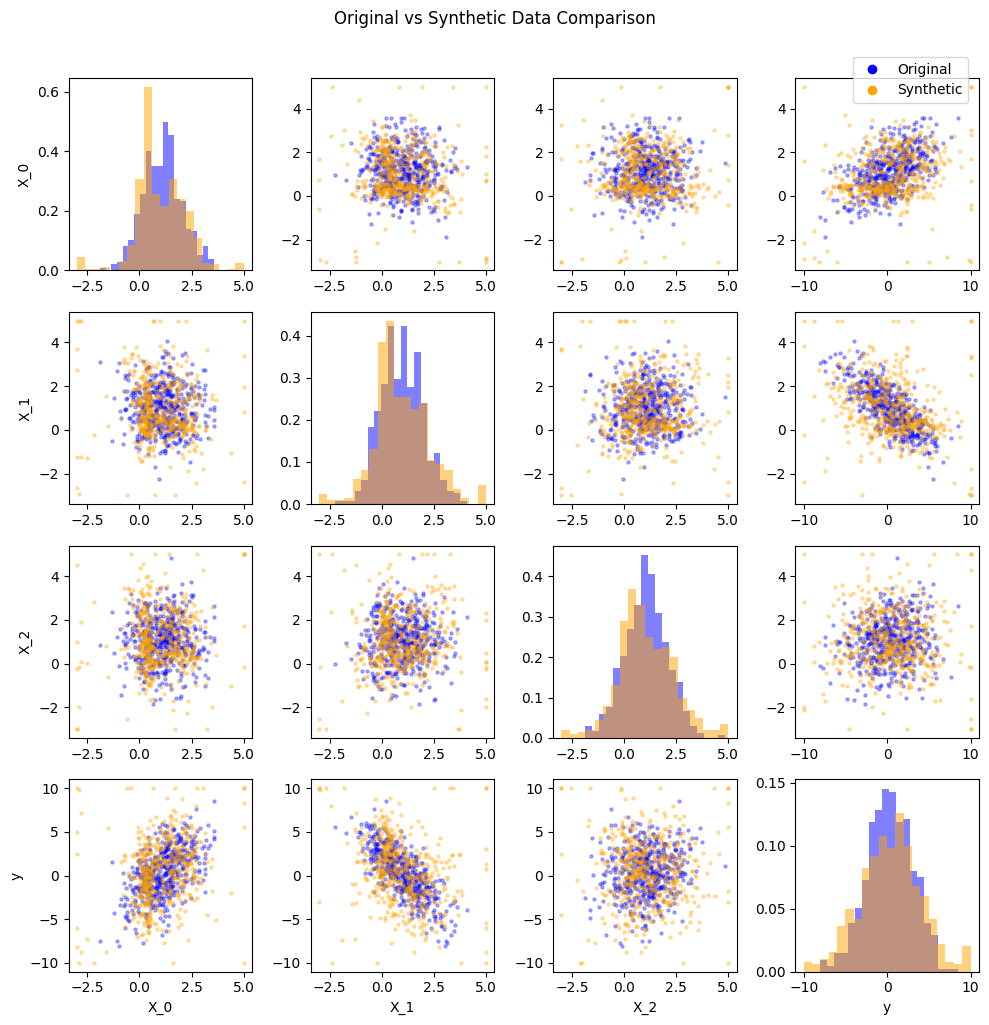

In [9]:
import matplotlib.pyplot as plt

if syn_result.n_samples > 0:
    # Scatter plot matrix (d+1) x (d+1)
    d = n_features
    labels = [f'X_{i}' for i in range(d)] + ['y']
    
    # Combine data for plotting
    orig_data = np.column_stack([X, y])
    syn_data = np.column_stack([X_syn, y_syn])
    
    fig, axes = plt.subplots(d+1, d+1, figsize=(10, 10))
    
    for i in range(d+1):
        for j in range(d+1):
            ax = axes[i, j]
            if i == j:
                # Diagonal: histograms
                ax.hist(orig_data[:, i], bins=20, alpha=0.5, color='blue', label='Original', density=True)
                ax.hist(syn_data[:, i], bins=20, alpha=0.5, color='orange', label='Synthetic', density=True)
            else:
                # Off-diagonal: scatter plots
                ax.scatter(orig_data[:, j], orig_data[:, i], alpha=0.3, s=5, c='blue', label='Original')
                ax.scatter(syn_data[:, j], syn_data[:, i], alpha=0.3, s=5, c='orange', label='Synthetic')
            
            if i == d:
                ax.set_xlabel(labels[j])
            if j == 0:
                ax.set_ylabel(labels[i])
    
    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Original'),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Synthetic')]
    fig.legend(handles=handles, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
    plt.suptitle('Original vs Synthetic Data Comparison', y=1.02)
    plt.tight_layout()
    plt.savefig('scatter_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Not enough synthetic samples generated.")

### Regression on Synthetic Data

In [10]:
if syn_result.n_samples >= n_features + 1:
    # OLS on synthetic data
    beta_syn = np.linalg.lstsq(X_syn, y_syn, rcond=None)[0]
    
    print("\n" + "="*50)
    print("REGRESSION: Original vs Synthetic")
    print("="*50)
    print(f"{'Feature':<10} {'True':<10} {'On Original':<14} {'On Synthetic':<14}")
    print("-"*48)
    
    for i in range(n_features):
        print(f"beta_{i:<5} {true_beta[i]:<10.3f} {beta_ols[i]:<14.3f} {beta_syn[i]:<14.3f}")
else:
    print("Not enough synthetic samples for regression.")


REGRESSION: Original vs Synthetic
Feature    True       On Original    On Synthetic  
------------------------------------------------
beta_0     1.500      1.526          0.861         
beta_1     -2.000     -2.018         -0.713        
beta_2     0.500      0.485          0.040         


---
## Part 4: Privacy Accounting

Understanding and converting between different privacy measures.

### $\mu$-GDP to $(\varepsilon, \delta)$-DP Conversion

Given $\mu$-GDP, we can convert to $(\varepsilon, \delta)$-DP:
- **Given $\varepsilon$**: compute $\delta$ using `delta_from_gdp(mu, eps)`
- **Given $\delta$**: compute $\varepsilon$ using `eps_from_mu_delta(mu, delta)`

In [11]:
from binagg import eps_from_mu_delta

mu = 1.0

# Given epsilon, compute delta
print("="*55)
print(f"Given mu={mu}, compute delta for various epsilon values:")
print("="*55)
print(f"{'epsilon':<12} {'delta':<15}")
print("-"*27)
for eps in [0.5, 1.0, 2.0, 3.0, 5.0]:
    delta = delta_from_gdp(mu, eps)
    print(f"{eps:<12.1f} {delta:<15.2e}")

print("\n")

# Given delta, compute epsilon
print("="*55)
print(f"Given mu={mu}, compute epsilon for various delta values:")
print("="*55)
print(f"{'delta':<15} {'epsilon':<12}")
print("-"*27)
for delta in [1e-3, 1e-5, 1e-7, 1e-9]:
    eps = eps_from_mu_delta(mu, delta)
    print(f"{delta:<15.0e} {eps:<12.2f}")

Given mu=1.0, compute delta for various epsilon values:
epsilon      delta          
---------------------------
0.5          2.38e-01       
1.0          1.27e-01       
2.0          2.09e-02       
3.0          1.54e-03       
5.0          5.79e-07       


Given mu=1.0, compute epsilon for various delta values:
delta           epsilon     
---------------------------
1e-03           3.14        
1e-05           4.38        
1e-07           5.35        
1e-09           6.17        


### Converting $(\varepsilon, \delta)$-DP to $\mu$-GDP

In [12]:
# Convert (epsilon, delta)-DP to mu-GDP
print("\n" + "="*50)
print("Converting (epsilon, delta)-DP to mu-GDP")
print("="*50)
print(f"{'epsilon':<12} {'delta':<15} {'mu':<10}")
print("-"*37)

for eps, delta in [(1.0, 1e-5), (1.0, 1e-6), (2.0, 1e-5), (0.5, 1e-5)]:
    mu = mu_from_eps_delta(eps, delta)
    print(f"{eps:<12.1f} {delta:<15.0e} {mu:<10.3f}")


Converting (epsilon, delta)-DP to mu-GDP
epsilon      delta           mu        
-------------------------------------
1.0          1e-05           0.268     
1.0          1e-06           0.237     
2.0          1e-05           0.502     
0.5          1e-05           0.142     


### Privacy Composition

In [13]:
# Four mechanisms each with mu=0.5
mus = [0.5, 0.5, 0.5, 0.5]
total_mu = compose_gdp(*mus)

print("\n" + "="*50)
print("PRIVACY COMPOSITION")
print("="*50)
print(f"Four mechanisms with mu=0.5 each:")
print(f"  GDP composition: mu_total = sqrt(4*0.5^2) = {total_mu:.3f}")
print(f"  (Compare to naive sum: 4*0.5 = 2.0)")
print("\nGDP composition is much tighter than naive composition!")


PRIVACY COMPOSITION
Four mechanisms with mu=0.5 each:
  GDP composition: mu_total = sqrt(4*0.5^2) = 1.000
  (Compare to naive sum: 4*0.5 = 2.0)

GDP composition is much tighter than naive composition!


### Budget Allocation

In [ ]:
total = 1.0
ratios = (1, 3, 3, 3)  # Default for binagg

budgets = allocate_budget(total, ratios)

print("\n" + "="*50)
print("BUDGET ALLOCATION")
print("="*50)
print(f"Total budget: mu = {total}")
print(f"Ratios: {ratios}")
print(f"\nAllocated budgets:")

names = ["binning", "counts", "sum_x", "sum_y"]
for name, b in zip(names, budgets):
    print(f"  {name:<10}: mu = {b:.4f}")

# Verify composition
composed = compose_gdp(*budgets)
print(f"\nVerification: sqrt(sum(mu^2)) = {composed:.6f}")


BUDGET ALLOCATION
Total budget: mu = 1.0
Ratios: (1, 3, 3, 3)

Allocated budgets:
  binning   : mu = 0.1890
  counts    : mu = 0.5669
  sum_x     : mu = 0.5669
  sum_y     : mu = 0.5669

Verification: sqrt(sum(mu^2)) = 1.000000


---
## Part 5: Practical Recommendations

### Choosing μ

| Use Case              | Recommended μ | Notes |
|----------------------|---------------|-------|
| High-stakes analysis | 0.1 – 0.5     | Strong privacy protection; expect (much) wider confidence intervals |
| Standard analysis    | ≈ 1.0         | Common balance between privacy and utility |
| Exploratory analysis | 1.5 – 3.0     | Weaker privacy guarantees; results closer to non-private analyses |


In [15]:
from binagg import eps_from_mu_delta

mu_used = 1.0
target_delta = 1e-5
eps_achieved = eps_from_mu_delta(mu_used, target_delta)

print("\n" + "="*60)
print("EXAMPLE PRIVACY STATEMENT")
print("="*60)
print(f"\n'This analysis satisfies mu={mu_used} Gaussian Differential Privacy,")
print(f" which implies (epsilon={eps_achieved:.2f}, delta={target_delta})-DP.'")


EXAMPLE PRIVACY STATEMENT

'This analysis satisfies mu=1.0 Gaussian Differential Privacy,
 which implies (epsilon=4.38, delta=1e-05)-DP.'


---
## Summary

The `binagg` package provides:

1. **`dp_linear_regression()`**: DP linear regression with valid confidence intervals
2. **`generate_synthetic_data()`**: DP synthetic data generation
3. **Privacy utilities**: `mu_to_epsilon()`, `delta_from_gdp()`, `compose_gdp()`, etc.

### Key Points

- Always specify bounds based on domain knowledge, not from data
- Start with $\mu=1.0$ and adjust based on your privacy/utility needs
- Confidence intervals are valid (asymptotically) even with DP noise
- GDP composition is much tighter than naive epsilon composition

### Citation

```bibtex
@article{lin2025differentially,
  title={Differentially Private Linear Regression and Synthetic Data 
         Generation with Statistical Guarantees},
  author={Lin, Shurong and Slavkovic, Aleksandra},
  journal={arXiv preprint arXiv:2510.16974},
  year={2025}
}
```